# X-Risk Exploratory Data Analysis

In this notebook we go through the existential risk database to learn about the estimates made by different people on the subject.

**Note from a human 🤓**: For this work, I used Claude AI to help me formulate some text sections and to help me process some data. I wrote most of it, and whatever I used from Claude I have thoroughly read. There are some sections entirely written by Claude AI though, which I've marked with 🤖. In those sections you'll find a "Note from a human 🤓" with an explanation.

In [633]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style='darkgrid')
orig_size = plt.rcParams['figure.figsize']

In [634]:
# Load the data
df = pd.read_csv('./data/processed_estimates/all_estimates.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   estimator                      83 non-null     object 
 1   original_estimate              83 non-null     object 
 2   per_century_risk               83 non-null     float64
 3   estimate_confidence            83 non-null     object 
 4   conversion_confidence          83 non-null     object 
 5   reasoning                      83 non-null     object 
 6   risk_category                  83 non-null     object 
 7   estimate_confidence_numeric    83 non-null     int64  
 8   conversion_confidence_numeric  83 non-null     int64  
 9   date                           83 non-null     int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 6.6+ KB


In [635]:
# Get the unique risk categories
xrisk_categories = set(df['risk_category'])
print(f'There are {len(xrisk_categories)} unique risk categories:\n-\t{"\n-\t".join(xrisk_categories)}')

There are 10 unique risk categories:
-	dystopia
-	nuclear
-	biorisk
-	natural_risks
-	miscellaneous
-	ai
-	war
-	climate_change
-	total
-	nanotechnology


# Initial Observations

With only 81 estimates spread across approximately 9-10 risk categories, we're working with an average of just 8-9 estimates per category. This limited data presents several important statistical challenges and implications.

The small sample size affects the reliability and robustness of our statistical analyses in multiple ways. 

First, with such limited data points per category, individual estimates carry disproportionate weight and outliers can significantly skew results. 

Second, traditional statistical tests and correlation analyses become less reliable with small sample sizes, as they typically require larger datasets to detect meaningful patterns with confidence.


In [636]:
categories_aliases = {
    "ai": "AI",
    "natural_risks": "Natural\nRisks",
    "nanotechnology": "Nanotech",
    "climate_change": "Climate\nChange",
    "war": "War",
    "miscellaneous": "Misc",
    "biorisk": "Biorisk",
    "total": "Total\nRisk",
    "dystopia": "Dystopia",
    "nuclear": "Nuclear",
}
df['category_alias'] = df['risk_category'].map(categories_aliases)


Text(0.5, 0, 'Risk category')

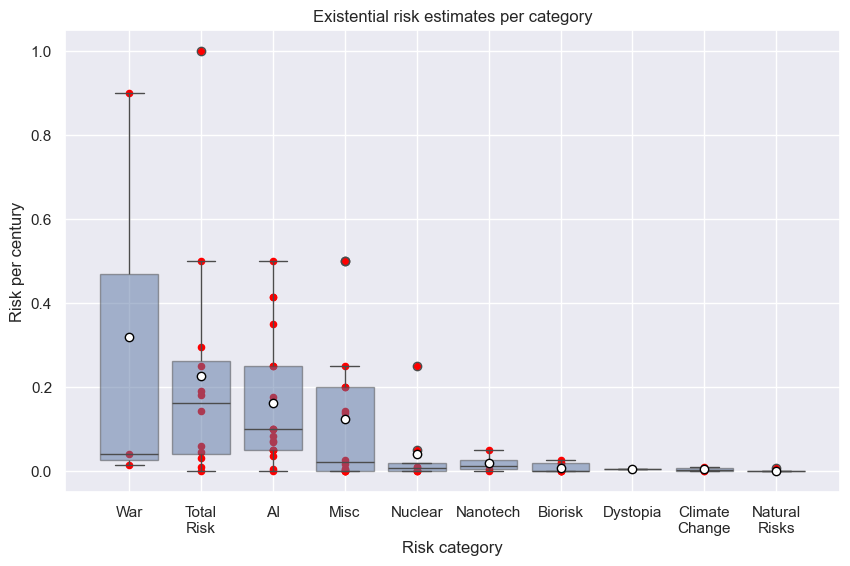

In [637]:
# Plot the risk categories as scatter plot.
ordered_categories_by_mean_risk = df.groupby('category_alias')['per_century_risk'].mean().sort_values(ascending=False).index

ax = sns.boxplot(x='category_alias', y='per_century_risk', data=df, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"}, boxprops=dict(alpha=0.5), order=ordered_categories_by_mean_risk)

df.plot(kind='scatter', x='category_alias', y='per_century_risk', color='red', figsize=(10, 6), ax=ax)

ax.set_title('Existential risk estimates per category')
ax.set_ylabel('Risk per century')
ax.set_xlabel('Risk category')


In [638]:
df.groupby('risk_category')['per_century_risk'].agg(['mean', 'median', 'std']).sort_values(by='median', ascending=False)

,mean,median,std
risk_category,,,
total,0.225332,0.161500,0.283787
ai,0.161579,0.100000,0.154940
war,0.318000,0.040000,0.504194
miscellaneous,0.124088,0.020850,0.170602
nanotechnology,0.017950,0.010850,0.022473
nuclear,0.040523,0.006500,0.086250
dystopia,0.005000,0.005000,NaN
climate_change,0.004233,0.003165,0.004815
biorisk,0.008032,0.000500,0.010398


### Observations - TLDR

- War shows the highest median risk (~30%) with extremely wide uncertainty
- Total risk and AI follow as second and third highest risks (~20% and ~15% median)
- Natural risks show the lowest estimates (<1%) with high confidence
- Nuclear, nanotech, and biorisk cluster in the low-but-significant range (1-5%)
- Most categories show significant spread in estimates, indicating expert disagreement
- Climate change estimates are notably low.

Let's visualize now the number of estimates per category. This might give us an insight into the fields or existential risks, that have been either explored the most or that have gained the most interest.

Text(0, 0.5, 'Count')

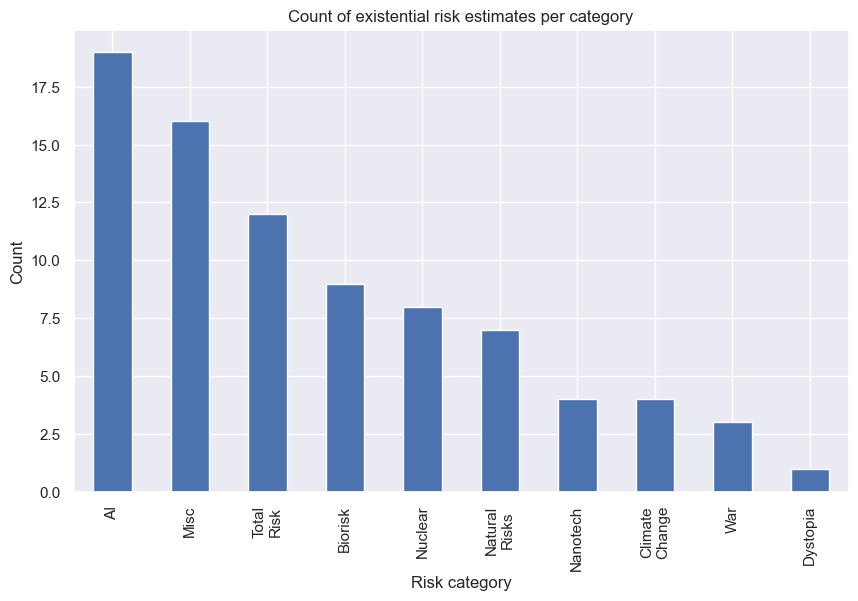

In [639]:
# Plot the count of estimates per category
ax = df['category_alias'].value_counts().plot(kind='bar', title='Count of existential risk estimates per category')
ax.set_xlabel('Risk category')
ax.set_ylabel('Count')

In [640]:
# Print the mean, median and std of the count of risk estimates per category
df['category_alias'].value_counts().agg(['mean', 'median', 'std'])

mean      8.300000
median    7.500000
std       5.850926
Name: count, dtype: float64

It is notable that AI has the most number of estimates. Also, the category Miscellaneous has a considerable number of estimates, even more than estimates for total risk.

We see that there's high standard deviation in the number of estimates per category, with a median of 7.5 (about the number of estimates for the category "Nuclear"), and a mean of 8.1. However, AI has the maximum number of estimates at 17.5, while Dystopia has only 1.

This might suggest that AI is a field that's gained a lot of attention. Later, in section [Time-Based Analysis](#time-based-analysis), we'll see if this is a trend that follows a temporal pattern.


# Outliers

There are a few outliers in the data which we'll look at more in detail, to see if they were perhaps conversion errors by Claude or something else.



## Nuclear

There's a value of 25% for nuclear risk which seems suspect, given that all other values are so low.


In [641]:
# Get outlier from nuclear category and risk above 20%
nuclear_outlier = df[(df['risk_category'] == 'nuclear') & (df['per_century_risk'] > 0.2)]
nuclear_outlier

,estimator,original_estimate,per_century_risk,estimate_confidence,conversion_confidence,reasoning,risk_category,estimate_confidence_numeric,conversion_confidence_numeric,date,category_alias
37,Dave Denkenberger,0.29% annual,0.25,medium,medium,Converted annual to century using compound pro...,nuclear,2,2,2018,Nuclear


In [642]:
# Print the value and reasoning
print(f'Reasoning: {nuclear_outlier["reasoning"].values[0]}')

Reasoning: Converted annual to century using compound probability: 1-(1-0.0029)^100.


Okay, so Claude tried to convert the value from 0.29% annual to a per century risk using compound probability, which he did correctly.

Let's confirm this:

I introduce the following variables and probabilities:

$$
\begin{align}
E&: \text{Existential catastrophe occurs} \\
P_1(E)&: \text{Existential risk per year}=0.0029 \\
P_{100}(E)&: \text{Existential risk per century}=?
\end{align}
$$

If the annual risk estimate is 0.29%, then we ask, how likely is it that this risk doesn't happen for 100 years in a row?

We can express that as: $(1-P_1(E))^{100}$, and the complement probability is that the risk will occur at least once in 100 years, so we get

$$
\begin{align}
P(R_1) &= 0.0029 \\
P(R_{100}) &= 1-P'(R_1)^{100} \\
P(R_{100}) &= 1-(1-P(R_1))^{100} \\
P(R_{100}) &= 1-(1-0.0029)^{100} \\
P(R_{100}) &\approx 0.252 \text{ or } 25\%
\end{align}
$$

To convert a period of size $a$ to another period of size $b$ we can simply replace the 100 years in the example by the number of times that period $a$ fits into $b$:

$$
P(R_{a}) = 1-(1-P(R_{b}))^{\frac{b}{a}}
$$

Claude also converted another value from 0.051% annual to 5% per century. By using the formulas above we get:

$$
\begin{align}
P(R_1) &= 0.00051 \\
P(R_{100}) &= 1-P'(R_1)^{100} \\
P(R_{100}) &= 1-(1-P(R_1))^{100} \\
P(R_{100}) &= 1-(1-0.00051)^{100} \\
P(R_{100}) &\approx 0.0497 \text{ or } 0.49\%
\end{align}
$$

So the conversion seems also correct.

## War

By looking at the data, the corresponding outlier is from an estimate by William MacAskill. The remarks were summarized as: 

> '90% conditional on x-risk occurring'.

I had to take a look at the original database to understand exactly what he meant, and it still is not very clear. In the remarks it says:

> In terms of my estimates for existential risk over the century, I would put 90% of the risk coming from wartime or something precisely because people… If you tell me someone’s done something, a country’s done something incredibly stupid and kind of against their own interest or in some sense of global interest, it’s probably happened during a war period.

Given this interpretation, we cannot validly calculate a specific war risk percentage from these statements. The 90% figure isn't a clean conditional probability that we can multiply with the 1% total risk to get his estimate for the likelihood of x-risk due to war. 

Instead, his statement describes war's role as a risk factor that interacts with and amplifies other existential risks. We'll remove the entry because it doesn't really reflect an x-risk estimate. However, we'll keep it in mind as an indication that there is at least one field expert who thinks that war is an important factor that clearly exacerbates other x-risks


In [643]:
# Remove war outlier
df = df[df['per_century_risk'] < 0.9]


### Total Risk
There's a value of 1, or 100% existential risk per century for Total Risk. Let's investigate.

In this case, I had to double check the original dataset, and it turns out that this estimator, Frank Tipler said, in 2019 "Personally, I now think we humans will be wiped out this century". So a 100% risk is actually accurate in this case.

First, should we remove this outlier? We might be tempted to drop such an extreme value. However, in existential risk assessment, we're dealing with expert opinions rather than natural phenomena where outliers might represent measurement errors.

Second, let's think about the nature of expert opinions. Unlike physical measurements where extreme outliers often represent errors, an extreme opinion might represent a genuinely held belief based on careful consideration. Frank Tipler is a physicist and mathematician who has published extensively on cosmology and the future of humanity. His estimate, while extreme, comes from his reasoning.

I find it notable though that his estimate was entered as "N/A" in the original database.

In [644]:
df[df['per_century_risk']> 0.9]

,estimator,original_estimate,per_century_risk,estimate_confidence,conversion_confidence,reasoning,risk_category,estimate_confidence_numeric,conversion_confidence_numeric,date,category_alias


## Misc

There's an outlier in the misc category.

In [645]:
df[(df['risk_category'] == 'miscellaneous') & (df['per_century_risk'] > 0.3)]

,estimator,original_estimate,per_century_risk,estimate_confidence,conversion_confidence,reasoning,risk_category,estimate_confidence_numeric,conversion_confidence_numeric,date,category_alias
61,Holden Karnofsky (human),≥50% PASTA impact this century,0.5,medium,high,Direct century estimate. Conditional on PASTA ...,miscellaneous,2,3,2021,Misc
63,Wei Dai,≥50% value loss from poor deliberation,0.5,medium,low,Unclear timeframe assumed to be century. Mediu...,miscellaneous,2,1,2021,Misc


It turns out that these estimates were directly given per century and are both at least 50%, so their values could be even higher. Claude gave them both a medium estimate confidence that reflects this uncertainty in the estimate.

## Correlation Analysis

We'll perform a correlation analysis to see if there are any significant correlations in the data.

In [646]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 0 to 82
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   estimator                      81 non-null     object 
 1   original_estimate              81 non-null     object 
 2   per_century_risk               81 non-null     float64
 3   estimate_confidence            81 non-null     object 
 4   conversion_confidence          81 non-null     object 
 5   reasoning                      81 non-null     object 
 6   risk_category                  81 non-null     object 
 7   estimate_confidence_numeric    81 non-null     int64  
 8   conversion_confidence_numeric  81 non-null     int64  
 9   date                           81 non-null     int64  
 10  category_alias                 81 non-null     object 
dtypes: float64(1), int64(3), object(7)
memory usage: 7.6+ KB


In [647]:
df.describe()

,per_century_risk,estimate_confidence_numeric,conversion_confidence_numeric,date
count,8.100000e+01,81.00000,81.000000,81.000000
mean,9.025236e-02,2.00000,2.666667,2016.111111
std,1.377480e-01,0.65192,0.612372,5.909738
min,8.300000e-10,1.00000,1.000000,1993.000000
25%,8.300000e-04,2.00000,2.000000,2015.000000
50%,1.900000e-02,2.00000,3.000000,2018.000000
75%,1.390000e-01,2.00000,3.000000,2020.000000
max,5.000000e-01,3.00000,3.000000,2023.000000


We have 4 numeric columns. Let's begin by plotting the columns against each other to see if any patterns come up.

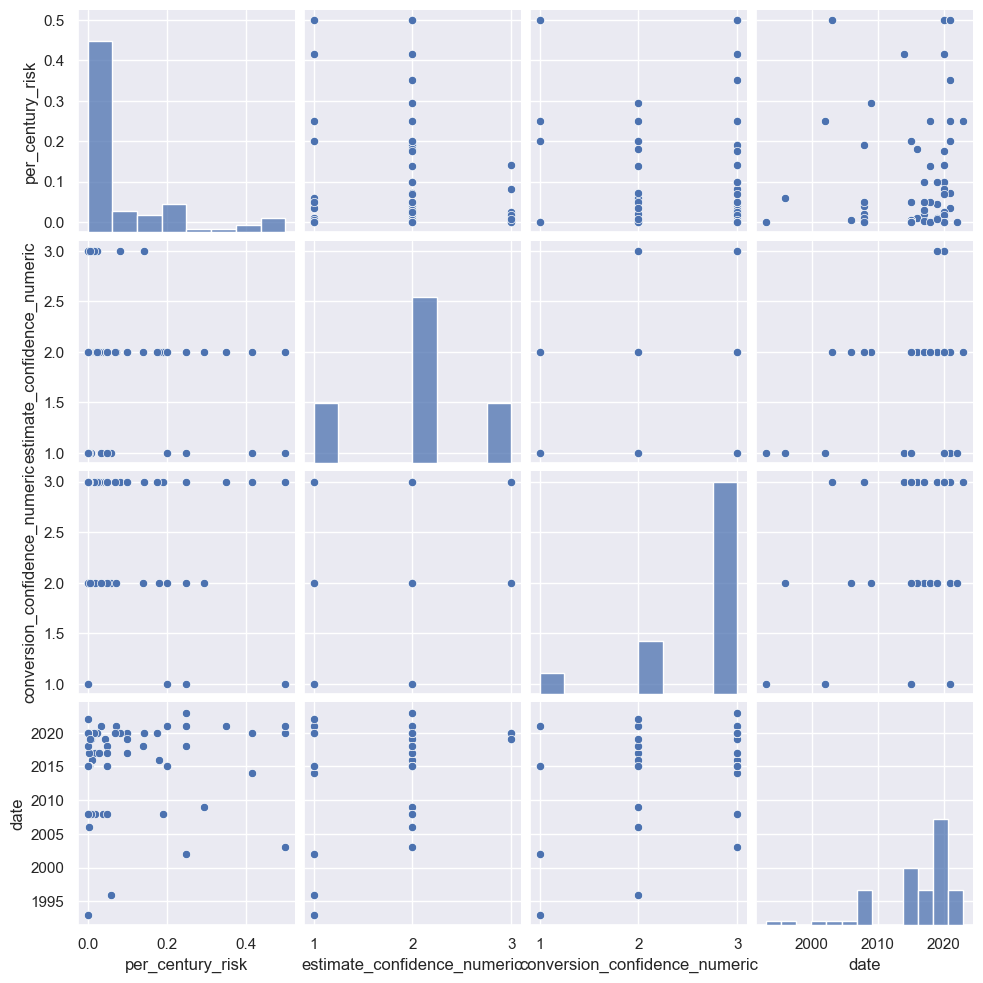

In [648]:
df_numeric = df[['per_century_risk', 'estimate_confidence_numeric', 'conversion_confidence_numeric', 'date']].copy()
sns.pairplot(df_numeric)

## Correlation Matrix

Let's now look at the correlation matrix, to see numerically how strong the columns might be correlated.

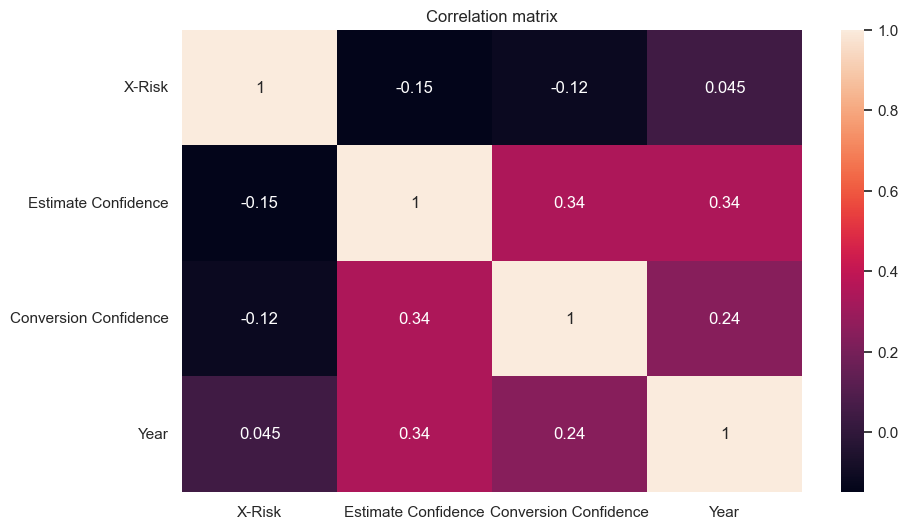

In [649]:
labels=['X-Risk', 'Estimate Confidence', 'Conversion Confidence', 'Year']
ax = sns.heatmap(df_numeric.corr(), annot=True, xticklabels=labels, yticklabels=labels)
ax.set_title('Correlation matrix')
plt.show()

### Observations

Looking at the correlation matrix and correlation plots, we can make the following observations:

1. Risk and Confidence Relationship:
- There's a slight negative correlation between X-Risk estimates and both confidence measures
- Estimate Confidence: -0.15
- Conversion Confidence: -0.12
- This suggests that higher risk estimates tend to come with slightly lower confidence levels, though the correlation is weak

2. Between Confidence Measures:
- There's a moderate positive correlation (0.34) between Estimate Confidence and Conversion Confidence
- This makes intuitive sense - estimates that are more confident in their base assessment tend to also be more confident in their conversion to century-scale risks

3. Temporal Trends:
- Year shows positive correlations with both confidence measures:
  - Estimate Confidence: 0.34
  - Conversion Confidence: 0.24
- This suggests that more recent estimates tend to have higher confidence levels
- There's a very weak positive correlation (0.045) between Year and X-Risk estimates, suggesting risk assessments haven't systematically increased or decreased over time

4. Strength of Correlations:
- None of the correlations are particularly strong (all < 0.5)
- The strongest correlations involve the confidence measures
- The weakest correlation is between Year and X-Risk (0.045)

These patterns suggest that while our confidence in making these estimates has increased over time, our assessment of the actual risks hasn't shown a strong directional trend. The negative correlation between risk estimates and confidence might indicate that experts become more cautious (less confident) when proposing higher risk estimates.

We also have to consider that we're dealing with a very small dataset. Maybe if we could increase the number of data points, we could reveal more robust insights.

# Time Based Analysis

Since we have data regarding when the observations were made, we could investigate if there is any correlation between the date when the estimate was made and the magnitude of the estimate. This would highlight a trend (if any), of whether experts are growing more or less concerned about existential risks as time passes.

Let's first view the magnitude of the analysis through time, as well as the count.

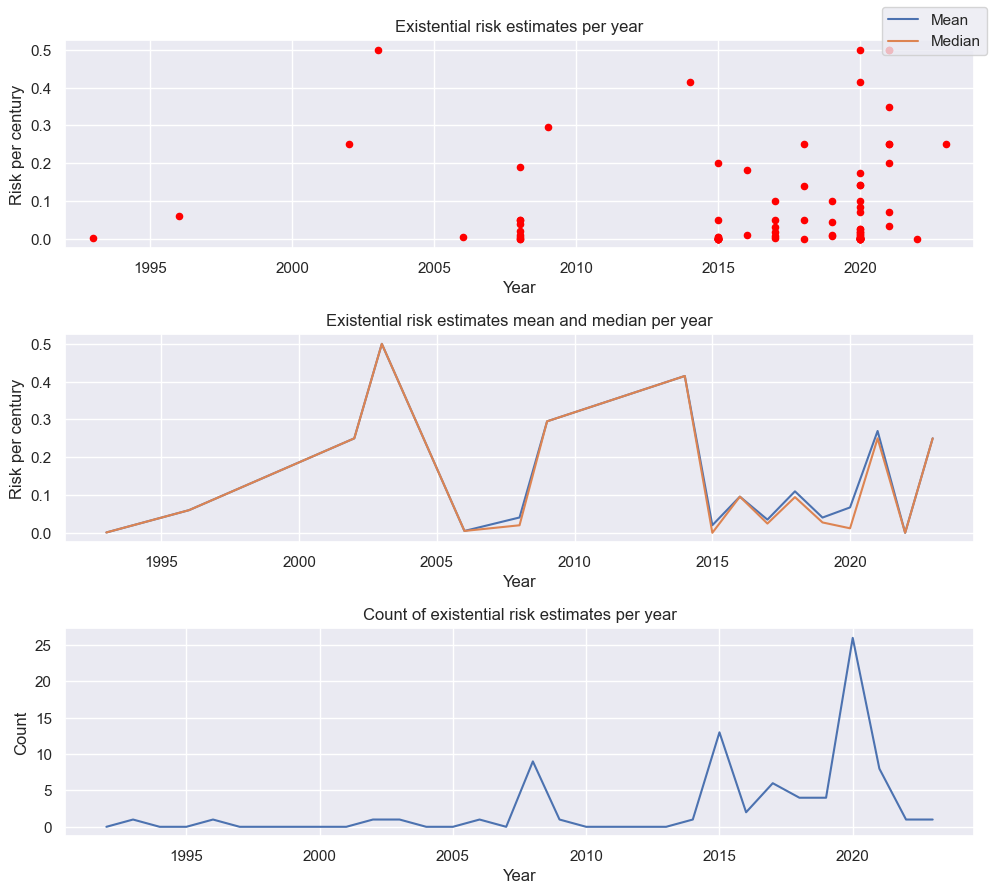

In [650]:
# Visualize the risk estimates through the years.
fig, axes = plt.subplots(3, figsize=(10, 9))
year_range = (df['date'].min()-1, df['date'].max()+1)

ax = axes[0]
df.plot(kind='scatter', x='date', y='per_century_risk', color='red', ax=ax)
ax.set_title('Existential risk estimates per year')
ax.set_ylabel('Risk per century')
ax.set_xlabel('Year')
ax.set_xlim(year_range)

ax = axes[1]
df.groupby('date')['per_century_risk'].mean().plot(ax=ax, label='Mean')
df.groupby('date')['per_century_risk'].median().plot(ax=ax, label='Median')
ax.set_title('Existential risk estimates mean and median per year')
ax.set_ylabel('Risk per century')
ax.set_xlabel('Year')
fig.legend()

# Visualize count of estimates per year
ax = axes[2]
value_count_per_year = np.zeros(year_range[1] - year_range[0])
for year in range(*year_range):
  value_count_per_year[year - year_range[0]] = df[df['date'] == year].shape[0]
ax.plot(range(*year_range), value_count_per_year)
ax.set_title('Count of existential risk estimates per year')
ax.set_ylabel('Count')
ax.set_xlabel('Year')
fig.tight_layout()

Based on these visualizations of existential risk estimates across all categories from 1995 to 2020, we can draw several important conclusions. The top scatter plot shows individual estimates becoming more frequent and more varied in recent years, with estimates ranging from near 0% to about 50% risk per century. The middle plot, showing mean and median trends, reveals notable volatility in expert estimates over time, with several significant spikes around 2005 and 2015 where estimates reached approximately 50% risk, though generally hovering between 10-30% in more recent years.

Perhaps most tellingly, the bottom plot demonstrates a dramatic increase in the number of existential risk estimates being made starting around 2015, with a particularly sharp peak in 2020. This surge in risk assessment activity suggests growing academic and professional interest in existential risks, possibly driven by rapid technological advancement and increasing awareness of global challenges. The higher frequency of estimates in recent years also provides a more robust dataset for analysis, though the wide spread of estimates indicates significant uncertainty and disagreement among experts about the magnitude of existential risks.

## Historical Context

Looking at the key time periods in the data, we can connect several significant historical events that likely influenced existential risk estimates:

*Early 2000s peak*: This period saw the aftermath of Y2K concerns, the 9/11 terrorist attacks, and growing awareness of climate change. The publication of influential works like Martin Rees' "Our Final Century" (2003) brought existential risks into broader academic discussion. These events highlighted humanity's vulnerability to both technological and human-made catastrophes.

*2015 surge*: This coincided with several watershed moments in technology and global risk awareness. The open letter warning about AI risks was published, signed by prominent figures like Stephen Hawking and Elon Musk. The Paris Climate Agreement highlighted growing concern about climate change. Additionally, the Global Challenges Foundation published their report on global catastrophic risks, which provided structured analysis of various existential threats.

*2020 peak*: The COVID-19 pandemic demonstrated how a global catastrophe could rapidly emerge and affect the entire world. This real-world example of a systemic risk likely prompted increased attention to existential risk assessment. This period also saw rapid advances in AI technology, particularly with GPT-3's release, which sparked new discussions about AI safety. The publication of Toby Ord's "The Precipice" provided a comprehensive framework for thinking about existential risks, likely inspiring many new estimates.

These historical contexts help explain why we see increased activity in risk assessment during these periods - each represented moments when global threats became more tangible to researchers and the public alike. 

# 🤖 Estimate Confidence Level Assessment Methodology

Claude AI gave per-century conversions for most estimates. Mostly the conversions look reasonable. But nonetheless, let's take a more detailed look at the confidence levels provided by Claude and see what conclusions we can draw.

## Note from a human 🤓

The following text section was entirely written by Claude AI. I asked it to explain in detail its methodology to come up with estimate confidence levels, so I thought I'd leave it as is, since any altering from my part would be not entirely appropriate. 

Here we can appreciate a disadvantage from using LLMs for this kind of thing, it might tell us a perfectly good explanation for why it came up with the numbers it came up with, but is it really true?... Isn't it similar with humans though?

## Enter Machine Talk 🤖

The confidence levels in the dataset represent an assessment of how reliable and well-supported each existential risk estimate appears to be. The evaluation uses a 3-point scale where:

- 1 = Low confidence
- 2 = Medium confidence 
- 3 = High confidence

## Primary Evaluation Criteria

### 1. Methodology Transparency

- **High (3)**: Clear explanation of calculation methods, assumptions, and data sources. Detailed reasoning provided.
- **Medium (2)**: Basic methodology explained but some assumptions unclear. General approach described.
- **Low (1)**: Limited or no explanation of methods. Unclear how estimate was derived.

### 2. Authority and Expertise

- **High (3)**: Estimate from recognized expert in the field with track record of research on existential risk.
- **Medium (2)**: Estimate from knowledgeable source but possibly outside their core expertise.
- **Low (1)**: Source's expertise unclear or estimate appears speculative.

### 3. Precision and Uncertainty

- **High (3)**: Appropriate level of precision given available data. Uncertainties acknowledged and quantified.
- **Medium (2)**: Some imprecision or oversimplification but generally reasonable.
- **Low (1)**: Overly precise given uncertainties, or extremely broad ranges suggesting high uncertainty.

### 4. Supporting Evidence

- **High (3)**: Based on empirical data, historical records, or well-established models.
- **Medium (2)**: Mix of data and reasoned speculation. Some supporting evidence.
- **Low (1)**: Primarily speculation or intuition with limited supporting evidence.

## Application Examples

### High Confidence Example

Toby Ord's estimate of nuclear risk (0.1% by 2120):

- Clear methodology explained in "The Precipice"
- Expert in existential risk assessment
- Appropriate level of precision
- Based on historical data and expert assessment
- Result: High confidence (3)

### Medium Confidence Example

GCR Conference estimates:

- Survey methodology explained but has inherent limitations
- Aggregates expert opinions but potential selection bias
- Reasonable precision levels
- Mix of evidence and expert judgment
- Result: Medium confidence (2)

### Low Confidence Example

Rough estimates marked with "~" or described as "order of magnitude":

- Limited methodological explanation
- High uncertainty acknowledged by author
- Very approximate nature
- Limited supporting evidence
- Result: Low confidence (1)

## Additional Considerations

1. **Time Sensitivity**

- More recent estimates generally received higher confidence than older ones, especially in rapidly evolving fields like AI risk.

2. **Author's Self-Assessment**

- When authors explicitly discussed confidence in their own estimates, this was weighted heavily in the assessment.

3. **Consensus Alignment**

- Estimates that significantly diverged from expert consensus required stronger justification to maintain high confidence.

4. **Field Maturity**

- Estimates in more mature fields (like natural disasters) could achieve higher confidence than those in emerging fields (like AI risk).

## Limitations

The confidence assessment itself has limitations:

1. Subjective judgment is inherently involved
2. Access to full methodological details varies across sources
3. Confidence in the estimate doesn't necessarily correlate with accuracy
4. The 3-point scale is a simplification of more nuanced differences in reliability

## Usage Notes

These confidence levels should be used to:

1. Weight different estimates appropriately in meta-analyses
2. Identify areas needing more robust research
3. Guide sensitivity analyses in risk calculations
4. Inform decision-making about risk mitigation priorities

Text(0.5, 0, 'Risk category')

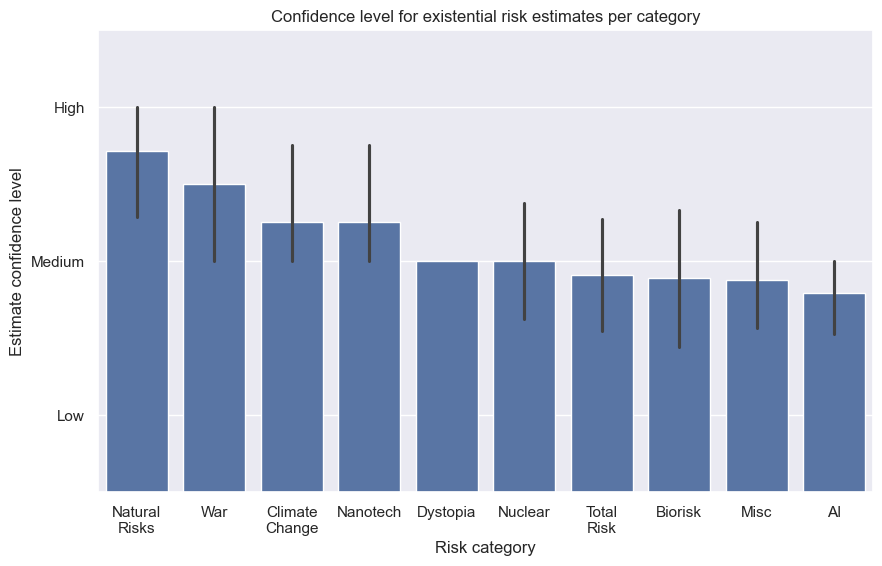

In [651]:
# Visualize the confidence level for each category.
# Plot the confidence level for each category sorted by confidence level.
categories_sorted_by_confidence = df.groupby('category_alias')['estimate_confidence_numeric'].mean().sort_values(ascending=False).index

# Set plot size to 10 by 6 inches
sns.set_theme(rc={'figure.figsize': (10, 6)})

# Create plot with seaborn
ax = sns.barplot(x='category_alias', y='estimate_confidence_numeric', data=df, order=categories_sorted_by_confidence)

# Set plot title, labels and ticks
ax.set_ylim(0.5, 3.5)
ax.set_yticks([1, 2, 3], ['Low', 'Medium', 'High'])
ax.set_title('Confidence level for existential risk estimates per category')
ax.set_ylabel('Estimate confidence level')
ax.set_xlabel('Risk category')

### Observations - TLDR 

- Natural risks have the highest estimate confidence, likely due to better scientific understanding and historical data
- AI and miscellaneous risks show the lowest confidence, possibly reflecting their emerging and complex nature
- War, climate change, and nanotech risks have moderately high confidence levels
- Nuclear risks show medium confidence, despite being a long-studied threat

### Observations - Detail

When we look at natural risks having the highest estimate confidence, this makes sense from multiple angles. We have historical data about supervolcanoes, asteroids, and other natural catastrophes. We understand their mechanisms well through scientific study. However, this high confidence might be somewhat misleading when considering existential risk specifically. It is important to remember that the actual existential risk due to natural disaster has a mean of 0.09%. While natural disasters could be devastating, these estimates suggest they might not pose as significant a threat to humanity's long-term potential as their high confidence rating suggests. Even a supervolcano eruption, while catastrophic, would likely leave some human populations surviving.

The lower confidence in AI risk estimates is particularly interesting. This lower confidence doesn't necessarily indicate a lower risk level - in fact, many experts consider AI one of the most serious existential threats (mean AI x-risk at 16% per century and mean of 1% as per this dataset). The low confidence instead reflects the complexity and unprecedented nature of artificial intelligence. AI poses unique challenges because it could affect humanity's trajectory in multiple ways: through direct extinction scenarios, by creating unaligned superintelligent systems, or by leading to dystopian outcomes that permanently diminish human potential. This multi-faceted nature of AI risk makes confident estimation inherently difficult.

War and nuclear risks show medium confidence levels, which reflects an interesting tension. On one hand, we have significant historical data about warfare and understand nuclear weapons' immediate effects well. However, the confidence isn't as high as natural risks because the cascading effects of modern warfare, especially considering technological advancement, are harder to predict. As mentioned in sources - like Toby Ord's The Precipice-and similar works, while nuclear war would be catastrophic, some experts argue it might not necessarily lead to human extinction - though it could severely impact our civilization's trajectory.

Climate change shows relatively high confidence, likely due to robust scientific modeling and understanding of physical mechanisms. However, this confidence might again need to be considered carefully in the context of existential risk specifically. While climate change poses severe challenges, its direct extinction potential might be lower than other risks-mean climate change x-risk estimate at 0.4%, median 0.3% per century-, though it could act as a risk factor that makes humanity more vulnerable to other threats.

The low confidence in miscellaneous risks makes sense as this category likely includes novel or poorly understood threats. However, this low confidence shouldn't be interpreted as low importance - unknown risks could be some of the most dangerous, precisely because we don't understand them well enough to prepare adequately.

What's particularly notable is how this confidence distribution somewhat inverts what many existential risk researchers consider to be the actual risk levels. The risks we're most confident in estimating (natural disasters) are often considered less likely to cause human extinction than risks we're less confident about estimating (like AI or unknown risks). This **suggests that our ability to confidently estimate a risk doesn't necessarily correlate with its actual potential to end human civilization** or prevent humanity from reaching its potential.

This analysis points to a crucial insight: we need to be careful not to conflate our confidence in estimating a risk with the severity or probability of that risk. Sometimes the hardest risks to estimate confidently might be the ones we need to worry about most.

The less confidence an expert has in their estimate, the vaguer the language they'll use to express their estimate. This results in higher uncertainty when trying to turn their estimates into a numeric value.

# 🤖 Time Period Conversion Confidence Assessment Methodology

The conversion confidence scores represent our level of certainty in converting risk estimates from their original timeframes to a standardized per-century metric. Like the estimate confidence, this uses a 3-point scale where:
- 1 = Low conversion confidence
- 2 = Medium conversion confidence
- 3 = High conversion confidence

## Primary Evaluation Criteria

### 1. Original Timeframe Clarity

- **High (3)**: Original timeframe explicitly stated with clear boundaries (e.g., "by 2100" or "in the next 100 years")
- **Medium (2)**: Timeframe implied or requires minor inference (e.g., "annual risk" requiring compound probability calculation)
- **Low (1)**: Timeframe ambiguous or requires significant assumptions (e.g., "in the long term" or "eventually")

### 2. Conversion Complexity

- **High (3)**: Direct century estimates or simple linear scaling needed
- **Medium (2)**: Requires compound probability calculations or moderate mathematical transformations
- **Low (1)**: Complex conversions with multiple assumptions or unclear mathematical relationship

### 3. Temporal Independence

- **High (3)**: Risk likely consistent over time or temporal dependence well-understood
- **Medium (2)**: Some temporal dependence but reasonably manageable
- **Low (1)**: Strong temporal dependence making conversion highly uncertain

### 4. Underlying Assumptions

- **High (3)**: Few necessary assumptions, all well-justified
- **Medium (2)**: Multiple assumptions required but reasonable
- **Low (1)**: Many assumptions or particularly strong assumptions needed

## Common Conversion Types and Their Typical Confidence Levels

### Direct Century Estimates

Example: "5% by 2100"

- No conversion needed
- Clear timeframe
- Typical confidence: High (3)

### Annual to Century Conversion

Example: "0.29% annual risk"

- Requires compound probability calculation: 1-(1-p)^100
- Assumes constant annual risk
- Typical confidence: Medium (2)

### Multi-Century to Century Conversion

Example: "5% before 5100 years"

- Requires significant assumptions about risk distribution
- Complex temporal scaling
- Typical confidence: Low (1)

### Near-Term to Century Conversion

Example: "2% by 2050"

- Requires scaling to full century
- Assumes linear risk scaling
- Typical confidence: Medium to High (2-3)

## Conversion Principles

### 1. Risk Distribution Assumptions

When converting estimates, we consider how risk might be distributed over time:
- Linear distribution: Risk increases steadily
- Front-loaded: Higher risk in earlier periods
- Back-loaded: Higher risk in later periods
- Uniform: Constant risk over time

### 2. Temporal Scaling Methods

Different approaches based on estimate type:
- Linear scaling: Multiplying by ratio of time periods
- Compound probability: Using probability theory for repeated independent events
- Conservative scaling: Using upper bounds when uncertainty is high

### 3. Special Cases

Some estimates require special handling:
- Conditional probabilities
- Cumulative risks
- Interconnected risks
- Threshold effects

## Limitations and Considerations

### Known Limitations

1. Assumption of time independence may not hold
2. Risk profiles might change dramatically over time
3. Complex interdependencies between different risks
4. Historical data might not predict future risks well

### Usage Guidelines

1. Consider conversion confidence alongside estimate confidence
2. Use more conservative estimates when conversion confidence is low
3. Acknowledge temporal uncertainties in analysis
4. Consider multiple conversion methods for sensitive analyses

## Examples with Reasoning

### High Conversion Confidence Example

Original: "1% by 2100"
- Already in century format
- No conversion needed
- Clear timeframe
- Result: High confidence (3)

### Medium Conversion Confidence Example

Original: "0.29% annual risk"
- Requires compound probability calculation
- Assumes constant annual risk
- Moderate mathematical transformation
- Result: Medium confidence (2)

### Low Conversion Confidence Example

Original: "5% over millions of years"

- Extremely long timeframe
- Many assumptions needed
- Complex temporal scaling
- Result: Low confidence (1)

## Recommendations for Use

1. **Primary Application**: Use conversion confidence to:
   - Weight different estimates in meta-analyses
   - Guide sensitivity testing
   - Inform uncertainty quantification
   - Prioritize data collection efforts

2. **Combined Analysis**: Consider both estimate and conversion confidence when:
   - Comparing different risk assessments
   - Making policy recommendations
   - Planning risk mitigation strategies
   - Communicating uncertainty to stakeholders

Text(0.5, 0, 'Risk category')

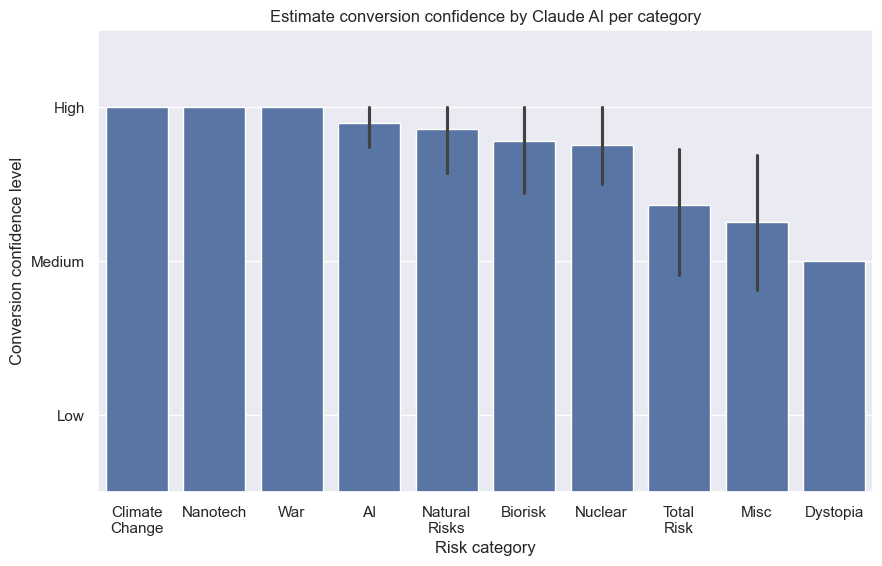

In [652]:
# Visualize the conversion confidence level for each category.

# Sort the categories by conversion confidence level
categories_sorted_by_conversion_confidence = df.groupby('category_alias')['conversion_confidence_numeric'].mean().sort_values(ascending=False).index

# Create plot with seaborn
ax = sns.barplot(x='category_alias', y='conversion_confidence_numeric', data=df, order=categories_sorted_by_conversion_confidence)

# Set plot title, labels and ticks
ax.set_ylim(0.5, 3.5)
ax.set_yticks([1, 2, 3], ['Low', 'Medium', 'High'])
ax.set_title('Estimate conversion confidence by Claude AI per category')
ax.set_ylabel('Conversion confidence level')
ax.set_xlabel('Risk category')

### Observations

The plot reveals several insights about conversion confidence across risk categories:

1. High consistency (no variance) in:
- Climate Change
- Nanotech 
- War
These categories show uniformly high conversion confidence, suggesting estimates typically use clear timeframes and straightforward conversions.

2. Moderate variance in:
- AI
- Natural Risks
- Biorisk
- Nuclear
These show some spread in conversion confidence, indicating a mix of estimate types - some with clear timeframes, others requiring more complex conversions.

3. High variance in:
- Total Risk
- Miscellaneous
These categories show the widest spread in conversion confidence, suggesting inconsistent estimation methods and timeframes.

4. Clear hierarchy:
- Climate Change, Nanotech, and War estimates are most reliably converted
- Miscellaneous and Dystopia estimates are least reliably converted

This pattern suggests that newer, more structured research fields tend to use more standardized timeframes, while broader or more speculative categories often use varied or less precise temporal frameworks.

The lower confidence in Total Risk conversion is particularly notable since it affects overall existential risk assessments. This suggests meta-analyses should carefully weight estimates based on conversion confidence.

**Question**: Could it be that the conversion confidence and the estimate confidence are correlated? 

**Hypothesis**: The less confidence an expert has in their estimate, the vaguer the language they'll use to express their estimate. This results in higher uncertainty when trying to turn their estimates into a numeric value.

However, I think this sort of analysis is out of the scope of this investigation. Since in the end, we're more interested in the overall risk estimates, rather on their metadata (like how estimate confidence and conversion confidence correlate). I'll just leave this hypothesis here as an interesting insight from looking at the data.

# Averaging

We now proceed to compute individual values for each category that "summarizes" the experts' opinions. This should naturally be taken with a big pinch of salt, given that the estimates vary a lot. We'll compute basic statistics, like mean and median, and so on, but also use the confidence levels to come up with weighted averages, that take into consideration the confidence level for each interval.

## Confidence Weights

We will introduce a metric that combines the estimate and the conversion confidence.

We can compute an arithmetic weight, by taking the sum of the two values and dividing by the maximum possible value. This assumes that both metrics are equally relevant.

Because the weights are given a value of 1,2 and 3 corresponding to low, medium and high. Thus, the maximum possible value would be 6. So we sum the two weights and divide by 6 to obtain a confidence weight.

In [653]:
# Let's first create a compound value - a weight - for the confidence levels.
df['confidence_weight'] = (df['estimate_confidence_numeric'] + df['conversion_confidence_numeric'])/6

/var/folders/gp/134vcy4x6c19634zvbkbff900000gn/T/ipykernel_18164/886898560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['confidence_weight'] = (df['estimate_confidence_numeric'] + df['conversion_confidence_numeric'])/6


We can now compute basic statistics, including a mean, and a weighted mean, which we do in the next cell.

In [ ]:


def compute_basic_stats(group):

    # Compute basic stats
    mean = group['per_century_risk'].mean()
    weighted_mean = np.average(group['per_century_risk'], weights=group['confidence_weight'])
    median = group['per_century_risk'].median()
    std = group['per_century_risk'].std()
    count = group.shape[0]
    q1, q3 = group['per_century_risk'].quantile([0.25, 0.75])

    return pd.Series({
        'category_alias': group['category_alias'].values[0],
        'mean': mean,
        'weighted_mean': weighted_mean,
        'confidence_weight_mean': group['confidence_weight'].mean(),
        'median': median,
        'std': std,
        'count': count,
        'q1': q1,
        'q3': q3,
        'iqr': q3 - q1,
    })

df_summary = df.groupby('risk_category')[[
        'risk_category', 
        'per_century_risk', 
        'estimate_confidence_numeric',
        'conversion_confidence_numeric', 
        'confidence_weight', 
        'category_alias'
    ]].apply(compute_basic_stats)
    
df_summary

,category_alias,mean,weighted_mean,confidence_weight_mean,median,std,count,q1,q3,iqr
risk_category,,,,,,,,,,
ai,AI,0.161579,0.160972,0.780702,0.100000,0.154940,19,5.000000e-02,0.250000,0.200000
biorisk,Biorisk,0.008032,0.008567,0.777778,0.000500,0.010398,9,2.000000e-06,0.019000,0.018998
climate_change,Climate\nChange,0.004233,0.004070,0.875000,0.003165,0.004815,4,6.475000e-04,0.006750,0.006103
dystopia,Dystopia,0.005000,0.005000,0.666667,0.005000,NaN,1,5.000000e-03,0.005000,0.000000
miscellaneous,Misc,0.124088,0.123296,0.687500,0.020850,0.170602,16,9.575000e-04,0.200000,0.199043
nanotechnology,Nanotech,0.017950,0.017890,0.875000,0.010850,0.022473,4,3.775000e-03,0.025025,0.021250
natural_risks,Natural\nRisks,0.000979,0.000881,0.928571,0.000001,0.002549,7,5.650000e-07,0.000046,0.000045
nuclear,Nuclear,0.040522,0.034519,0.791667,0.006500,0.086250,8,6.975000e-04,0.020000,0.019303
total,Total\nRisk,0.154907,0.155808,0.712121,0.142000,0.152058,11,3.750000e-02,0.220000,0.182500


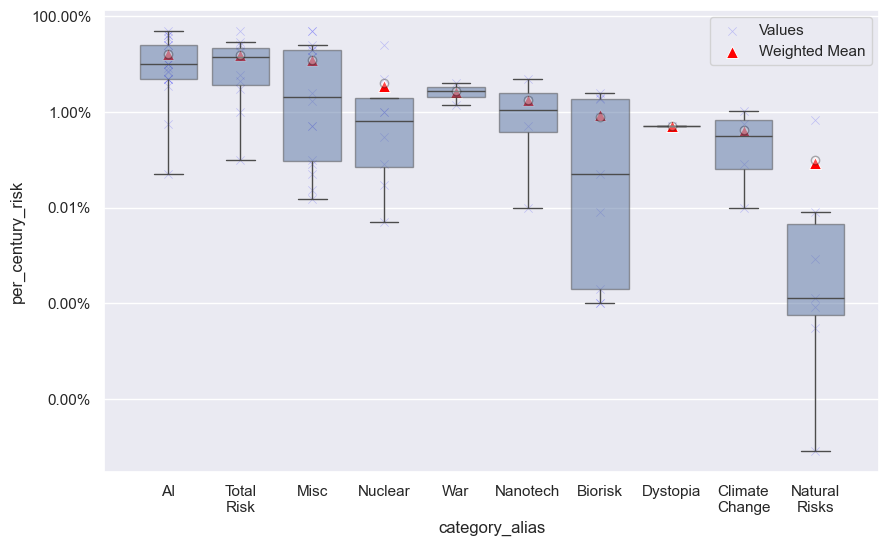

In [655]:
from matplotlib.ticker import FuncFormatter

# Sort the categories by mean
categories_sorted_by_mean = df_summary.sort_values(by='mean', ascending=False)['category_alias']

# Visualize the results of the mean and weighted means on top of a box plot to see how they differ from the standard ones
ax = sns.boxplot(
  x='category_alias', y='per_century_risk', 
  data=df, showmeans=True, 
  meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "alpha":0.3}, 
  boxprops=dict(alpha=0.5), 
  order=categories_sorted_by_mean,
  showfliers=False)

ax = sns.scatterplot(x='category_alias', y='per_century_risk', data=df, label='Values', marker='x', color='blue', alpha=0.2)

ax = sns.scatterplot(x='category_alias', y='weighted_mean', data=df_summary, label='Weighted Mean', marker='^', color='red', s=75)
ax.set_yscale('log')

# Format the y-axis as percentage
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

plt.show()


As we can see the weighted means do not change too much from the normal mean.

Because we're dealing with data that is relatively widely spread, we'll also compute a geometric mean.

In [656]:
def compute_geometric_mean(group):

    return pd.Series({
        'geometric_mean': np.exp(np.sum(np.log(group['per_century_risk']))/len(group))
    })

df_geometric_mean = df.groupby('risk_category')[['risk_category', 'per_century_risk']].apply(compute_geometric_mean)
df_geometric_mean

df_summary['geometric_mean'] = df_geometric_mean['geometric_mean']

df_summary[['mean', 'weighted_mean', 'geometric_mean']]

,mean,weighted_mean,geometric_mean
risk_category,,,
ai,0.161579,0.160972,0.080536
biorisk,0.008032,0.008567,0.000263
climate_change,0.004233,0.004070,0.001480
dystopia,0.005000,0.005000,0.005000
miscellaneous,0.124088,0.123296,0.015109
nanotechnology,0.017950,0.017890,0.004520
natural_risks,0.000979,0.000881,0.000003
nuclear,0.040522,0.034519,0.003834
total,0.154907,0.155808,0.067965


We notice that the geometric mean is significantly lower for most risk categories, except for dystopia, which only has one estimate. Let's see how it looks like when plotted against the arithmetic mean.

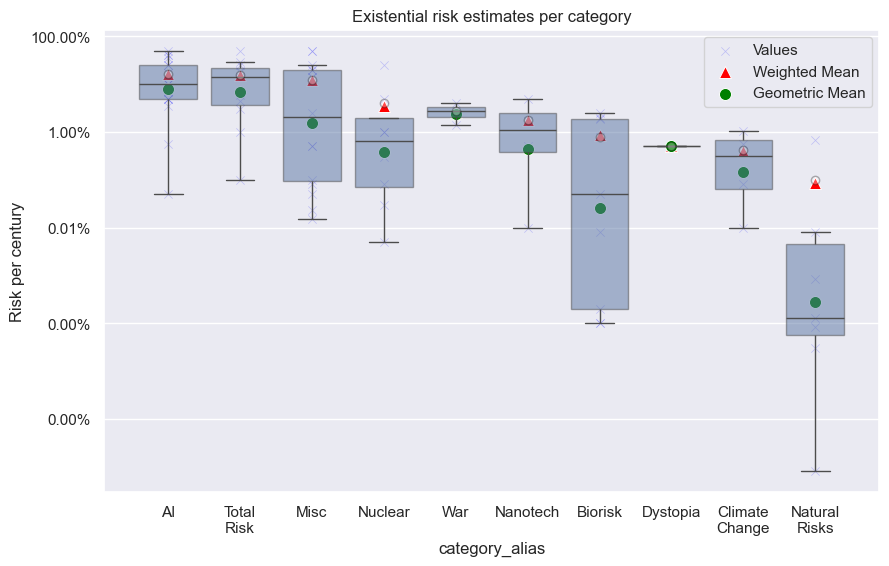

In [657]:
# Sort the categories by mean
categories_sorted_by_mean = df_summary.sort_values(by='mean', ascending=False)['category_alias']

# Visualize the results of the mean and weighted means on top of a box plot to see how they differ from the standard ones
ax = sns.boxplot(
  x='category_alias', y='per_century_risk', 
  data=df, showmeans=True, 
  meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "alpha":0.3}, 
  boxprops=dict(alpha=0.5), 
  order=categories_sorted_by_mean,
  showfliers=False)

ax = sns.scatterplot(x='category_alias', y='per_century_risk', data=df, label='Values', marker='x', color='blue', alpha=0.2)

ax = sns.scatterplot(x='category_alias', y='weighted_mean', data=df_summary, label='Weighted Mean', marker='^', color='red', s=75)
ax.set_yscale('log')

sns.scatterplot(x='category_alias', y='geometric_mean', data=df_summary, label='Geometric Mean', marker='o', color='green', s=75)

# Format the y-axis as percentage
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
ax.set_title('Existential risk estimates per category')
ax.set_ylabel('Risk per century')
plt.show()

We can see that the geometric mean looks somewhat closer to the median and more often than not inside the IQR. This is probably due to the fact that the geometric mean is less sensitive to extreme values than the arithmetic mean. It might be a good idea to use the geometric mean instead of the arithmetic mean.

Now, as a final step in this section, let's use the confidence weights to compute a weighted geometric mean. 

According to our previous analysis, there's a slight inverse correlation between the estimates' magnitude and the confidence level, meaning that the highest the confidence, the lower the estimate's magnitude - though not always. Maybe this will cause the weighted geometric means to be slightly lower than the unweighted ones for the values where the confidence is highest.

In [663]:
def weighted_geometric_mean(group):
    """
    Calculate the weighted geometric mean of the 'per_century_risk' column in a DataFrame group.

    Parameters:
    group (pd.DataFrame): A pandas DataFrame containing at least the columns 'per_century_risk' and 'confidence_weight'.

    Returns:
    pd.Series: A pandas Series with a single value 'weighted_geometric_mean' representing the weighted geometric mean of the 'per_century_risk' values.
    """
    
    weighted_geo_mean = np.exp(np.average(np.log(group['per_century_risk']), weights=group['confidence_weight']))
    return pd.Series({
        'weighted_geometric_mean': weighted_geo_mean
    })

df_summary['weighted_geometric_mean'] = df.groupby('risk_category')[['per_century_risk', 'confidence_weight']].apply(weighted_geometric_mean)['weighted_geometric_mean']
df_summary
df_summary[['mean', 'weighted_mean', 'geometric_mean', 'weighted_geometric_mean']]

,mean,weighted_mean,geometric_mean,weighted_geometric_mean
risk_category,,,,
ai,0.161579,0.160972,0.080536,0.084158
biorisk,0.008032,0.008567,0.000263,0.000348
climate_change,0.004233,0.004070,0.001480,0.001439
dystopia,0.005000,0.005000,0.005000,0.005000
miscellaneous,0.124088,0.123296,0.015109,0.018336
nanotechnology,0.017950,0.017890,0.004520,0.004811
natural_risks,0.000979,0.000881,0.000003,0.000002
nuclear,0.040522,0.034519,0.003834,0.003007
total,0.154907,0.155808,0.067965,0.076293


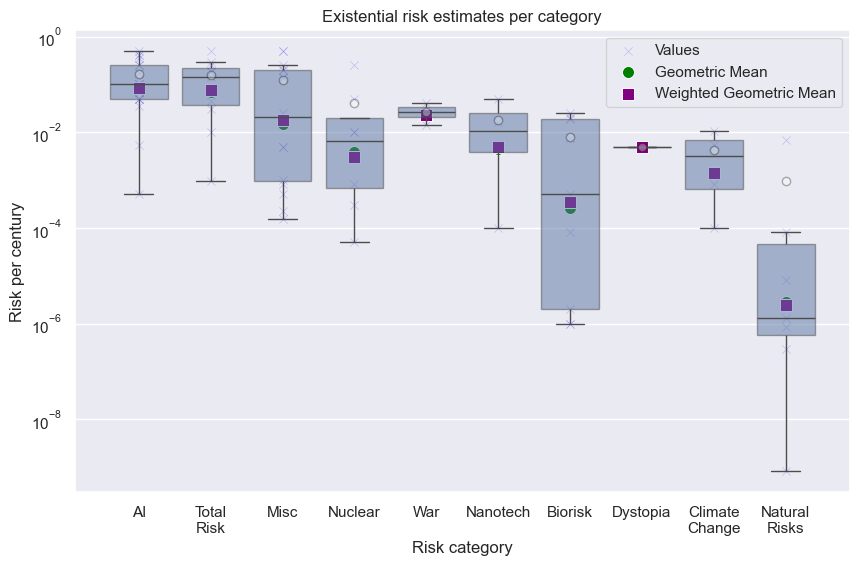

In [ ]:
# Sort the categories by mean
categories_sorted_by_mean = df_summary.sort_values(by='mean', ascending=False)['category_alias']

# Visualize the results of the mean and weighted means on top of a box plot to see how they differ from the standard ones
ax = sns.boxplot(
  x='category_alias', y='per_century_risk', 
  data=df, showmeans=True, 
  meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "alpha":0.3}, 
  boxprops=dict(alpha=0.5), 
  order=categories_sorted_by_mean,
  showfliers=False)

ax = sns.scatterplot(x='category_alias', y='per_century_risk', data=df, label='Values', marker='x', color='blue', alpha=0.2)

sns.scatterplot(x='category_alias', y='geometric_mean', data=df_summary, label='Geometric Mean', marker='o', color='green', s=75)

sns.scatterplot(x='category_alias', y='weighted_geometric_mean', data=df_summary, label='Weighted Geometric Mean', marker='s', color='purple', s=75)

# Format the y-axis as percentage
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
ax.set_title('Existential risk estimates per category')
ax.set_ylabel('Risk per century')
ax.set_yscale('log')

ax.set_xlabel('Risk category')
ax.set_ylabel('Risk per century')

plt.show()

It seems that actually the difference between the geometric mean and weighted geometric mean is also very slight.

In [ ]:
# Save the values to a csv file
df_summary.to_csv('./data/processed_estimates/summary_estimates.csv', index=False)
df.to_csv('./data/processed_estimates/all_estimates_cleaned.csv', index=False)

# Conclusions

We analyzed what experts think about humanity's biggest risks by looking at 81 different estimates across various types of threats. Here's what we discovered about the potential risks to humanity's future.

## Key Findings About Risk Levels

### Highest Risk Categories
Artificial intelligence and overall catastrophic risks emerged as our biggest concerns, with experts estimating around a 15-20% chance of something going seriously wrong this century.

### Medium Risk Categories
Most risks like nuclear war, nanotechnology gone wrong, and biological threats fell in the middle range. Experts suggested roughly a 1-5% chance of catastrophe per century from these threats.

### Lowest Risk Category
Natural disasters showed the lowest risk - less than 1% chance per century. Interestingly, experts were most confident about these estimates because we have good historical data about events like asteroids and volcanoes.

## Temporal Patterns and Trends

We noticed some interesting patterns in when these estimates were made:
- A significant increase in the number of expert predictions after 2015
- A particular surge around 2020
- These spikes might reflect growing concerns about AI and other technological risks
- The COVID-19 pandemic likely served as a wake-up call, prompting more risk assessment

## The Confidence Paradox

We discovered an intriguing pattern: when experts were more confident about their predictions, they usually gave lower risk estimates. Conversely, when they were less sure, they tended to predict higher risks. This makes sense - the threats we understand better (like natural disasters) seem less dangerous than the ones we're still trying to figure out (like advanced AI).

## Methodology and Limitations

### Dataset Constraints
- Our analysis used only 81 estimates spread across 9-10 categories
- This small sample size limits the statistical strength of our conclusions
- Experts used different timeframes and methods of expressing risk
- We had to convert everything to a per-century format, adding some uncertainty

### Analysis Techniques
We employed several mathematical approaches to handle the data effectively:
- Used geometric means instead of regular averages to better handle extreme values
- Created a confidence scoring system to give more weight to reliable estimates
- Converted different time scales to a common century-based format

### Potential Further Analysis
While we could have conducted additional analyses (like examining expert backgrounds or trying different weighting methods), we reached a point of diminishing returns. Given our small dataset and the inherent uncertainty in predicting existential risks, further analysis would likely not yield significantly more insights.

## Conclusions and Next Steps

### Main Takeaways
- AI and overall catastrophic risks are the experts' primary concerns
- Medium-level concern exists for nuclear war and bioweapons
- Natural disasters rank as the least worrying threats
- However, these are educated guesses about extremely complex and uncertain events

### Moving Forward
Our next step is to use these estimates to model potential survival scenarios for humanity. While our analysis isn't perfect, it provides a solid foundation based on the best available expert knowledge.

### A Note of Caution
Remember that these estimates represent expert opinions about highly uncertain events. They serve as a starting point for understanding potential risks to humanity's future, not as definitive predictions. The variation in expert opinions and confidence levels reminds us to maintain a balanced perspective when considering these existential risks.